<a href="https://www.bigdatauniversity.com"><img src="https://ibm.box.com/shared/static/cw2c7r3o20w9zn8gkecaeyjhgw3xdgbj.png" width="400" align="center"></a>

<h1 align="center"><font size="5">Classification with Python</font></h1>

In this notebook we try to practice all the classification algorithms that we learned in this course.

We load a dataset using Pandas library, and apply the following algorithms, and find the best one for this specific dataset by accuracy evaluation methods.

Lets first load required libraries:

In [1]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import pandas as pd
import numpy as np
import matplotlib.ticker as ticker
from sklearn import preprocessing
%matplotlib inline

### About dataset

This dataset is about past loans. The __Loan_train.csv__ data set includes details of 346 customers whose loan are already paid off or defaulted. It includes following fields:

| Field          | Description                                                                           |
|----------------|---------------------------------------------------------------------------------------|
| Loan_status    | Whether a loan is paid off on in collection                                           |
| Principal      | Basic principal loan amount at the                                                    |
| Terms          | Origination terms which can be weekly (7 days), biweekly, and monthly payoff schedule |
| Effective_date | When the loan got originated and took effects                                         |
| Due_date       | Since it’s one-time payoff schedule, each loan has one single due date                |
| Age            | Age of applicant                                                                      |
| Education      | Education of applicant                                                                |
| Gender         | The gender of applicant                                                               |

Lets download the dataset

In [ ]:
!wget -O loan_train.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_train.csv

In [2]:
### Load Data From CSV File  

In [31]:
df = pd.read_csv('loan_train.csv')
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,9/8/2016,10/7/2016,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,9/8/2016,10/7/2016,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,9/8/2016,9/22/2016,27,college,male
3,4,4,PAIDOFF,1000,30,9/9/2016,10/8/2016,28,college,female
4,6,6,PAIDOFF,1000,30,9/9/2016,10/8/2016,29,college,male


In [32]:
df.shape

(346, 10)

### Convert to date time object 

In [33]:
df['due_date'] = pd.to_datetime(df['due_date'])
df['effective_date'] = pd.to_datetime(df['effective_date'])
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male


# Data visualization and pre-processing



Let’s see how many of each class is in our data set 

In [34]:
df['loan_status'].value_counts()

PAIDOFF       260
COLLECTION     86
Name: loan_status, dtype: int64

260 people have paid off the loan on time while 86 have gone into collection 


Lets plot some columns to underestand data better:

In [35]:
# notice: installing seaborn might takes a few minutes
!conda install -c anaconda seaborn -y

Solving environment: done

# All requested packages already installed.



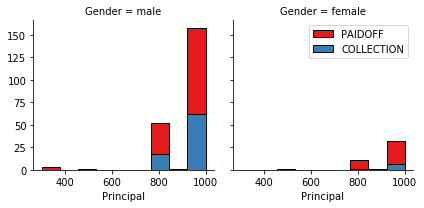

In [36]:
import seaborn as sns

bins = np.linspace(df.Principal.min(), df.Principal.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'Principal', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

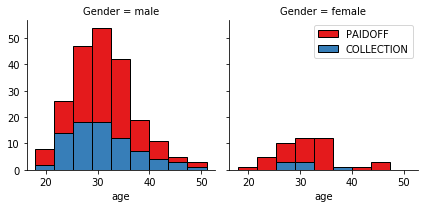

In [37]:
bins = np.linspace(df.age.min(), df.age.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'age', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

# Pre-processing:  Feature selection/extraction

### Lets look at the day of the week people get the loan 

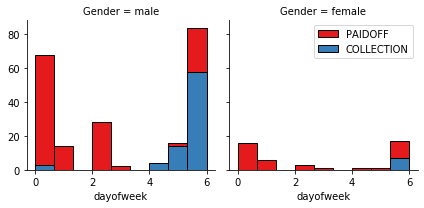

In [39]:
df['dayofweek'] = df['effective_date'].dt.dayofweek
bins = np.linspace(df.dayofweek.min(), df.dayofweek.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'dayofweek', bins=bins, ec="k")
g.axes[-1].legend()
plt.show()


We see that people who get the loan at the end of the week dont pay it off, so lets use Feature binarization to set a threshold values less then day 4 

In [41]:
df['weekend'] = df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male,4,1


## Convert Categorical features to numerical values

Lets look at gender:

In [42]:
df.groupby(['Gender'])['loan_status'].value_counts(normalize=True)

Gender  loan_status
female  PAIDOFF        0.865385
        COLLECTION     0.134615
male    PAIDOFF        0.731293
        COLLECTION     0.268707
Name: loan_status, dtype: float64

86 % of female pay there loans while only 73 % of males pay there loan


Lets convert male to 0 and female to 1:


In [43]:
df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,0,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,1,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,0,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,1,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,0,4,1


## One Hot Encoding  
#### How about education?

In [44]:
df.groupby(['education'])['loan_status'].value_counts(normalize=True)

education             loan_status
Bechalor              PAIDOFF        0.750000
                      COLLECTION     0.250000
High School or Below  PAIDOFF        0.741722
                      COLLECTION     0.258278
Master or Above       COLLECTION     0.500000
                      PAIDOFF        0.500000
college               PAIDOFF        0.765101
                      COLLECTION     0.234899
Name: loan_status, dtype: float64

#### Feature befor One Hot Encoding

In [45]:
df[['Principal','terms','age','Gender','education']].head()

,Principal,terms,age,Gender,education
0,1000,30,45,0,High School or Below
1,1000,30,33,1,Bechalor
2,1000,15,27,0,college
3,1000,30,28,1,college
4,1000,30,29,0,college


#### Use one hot encoding technique to conver categorical varables to binary variables and append them to the feature Data Frame 

In [181]:
Feature = df[['Principal','terms','age','Gender','weekend']]
Feature = pd.concat([Feature,pd.get_dummies(df['education'])], axis=1)
Feature.drop(['Master or Above'], axis = 1,inplace=True)
Feature.head()


,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


In [47]:
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,0,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,1,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,0,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,1,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,0,4,1


### Feature selection

Lets defind feature sets, X:

In [182]:
X = Feature
X[0:5]

,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


What are our lables?

In [192]:
y = df['loan_status'].values
y[0:5]

array(['PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF'],
      dtype=object)

## Normalize Data 

Data Standardization give data zero mean and unit variance (technically should be done after train test split )

In [50]:
X= preprocessing.StandardScaler().fit(X).transform(X)
X[0:5]

array([[ 0.51578458,  0.92071769,  2.33152555, -0.42056004, -1.20577805,
        -0.38170062,  1.13639374, -0.86968108],
       [ 0.51578458,  0.92071769,  0.34170148,  2.37778177, -1.20577805,
         2.61985426, -0.87997669, -0.86968108],
       [ 0.51578458, -0.95911111, -0.65321055, -0.42056004, -1.20577805,
        -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.48739188,  2.37778177,  0.82934003,
        -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.3215732 , -0.42056004,  0.82934003,
        -0.38170062, -0.87997669,  1.14984679]])

# Classification 

Now, it is your turn, use the training set to build an accurate model. Then use the test set to report the accuracy of the model
You should use the following algorithm:
- K Nearest Neighbor(KNN)
- Decision Tree
- Support Vector Machine
- Logistic Regression



__ Notice:__ 
- You can go above and change the pre-processing, feature selection, feature-extraction, and so on, to make a better model.
- You should use either scikit-learn, Scipy or Numpy libraries for developing the classification algorithms.
- You should include the code of the algorithm in the following cells.

# K Nearest Neighbor(KNN)
Notice: You should find the best k to build the model with the best accuracy.  
**warning:** You should not use the __loan_test.csv__ for finding the best k, however, you can split your train_loan.csv into train and test to find the best __k__.

In [191]:
# In this cell, we prepare the test dataset in advance, since the evaluation metrics are a part of every
# models development, therefore the test_set has to already be available to be used to calculate out-of-
# sample accuracy. Since we're already doing this procedure here, there is no need to repeat it in the 
# final evaluation report written at the end of this notebook, so there there will be a reference to this
# cell.

df_test = pd.read_csv("loan_test.csv")

# Transforming the two date columns to datetime format
df_test['due_date'] = pd.to_datetime(df_test['due_date'])
df_test['effective_date'] = pd.to_datetime(df_test['effective_date'])

# Creating the dayofweek and weekend column
df_test['dayofweek'] = df_test['effective_date'].dt.dayofweek
df_test['weekend'] = df_test['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)

# Transforming the gender column to 0's and 1's.
df_test['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)




# Extracting the features and target variables for the test set.
Feature_test = df_test[['Principal','terms','age','Gender','weekend']]
Feature_test = pd.concat([Feature_test,pd.get_dummies(df_test['education'])], axis=1)
Feature_test.drop(['Master or Above'], axis = 1,inplace=True)
X_test = Feature_test
y_test = df_test['loan_status'].values

In [56]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics

Ks = 10
mean_acc = np.zeros((Ks-1))
std_acc = np.zeros((Ks-1))
ConfustionMx = [];

# Here we create a for loop that will iterate through different K numbers from 1 to 10 (or whatever specified
# above in the "Ks" variable. In this loop, the model is trained for that given value of K and then tested.
for n in range(1,Ks):
    
    # Here we train the model and make a prediction, the latter being made based on the test set, extracted
    # from the testing part of this notebook at the end, and loaded in the cell above this one.
    knn_mod = KNeighborsClassifier(n_neighbors = n).fit(X,y)
    yhat=knn_mod.predict(X_test)
    mean_acc[n-1] = metrics.accuracy_score(y_test, yhat)
    std_acc[n-1]=np.std(yhat==y_test)/np.sqrt(yhat.shape[0])

mean_acc

array([0.53703704, 0.25925926, 0.61111111, 0.51851852, 0.72222222,
       0.74074074, 0.74074074, 0.74074074, 0.74074074])

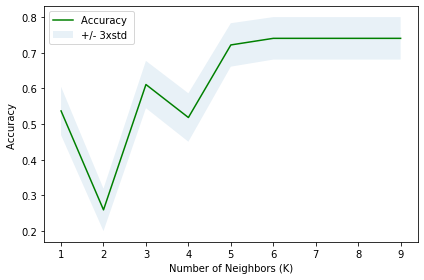

In [58]:
plt.plot(range(1,Ks),mean_acc,'g')
plt.fill_between(range(1,Ks),mean_acc - 1 * std_acc,mean_acc + 1 * std_acc, alpha=0.10)
plt.legend(('Accuracy ', '+/- 3xstd'))
plt.ylabel('Accuracy ')
plt.xlabel('Number of Neighbors (K)')
plt.tight_layout()
plt.show()

In [59]:
print( "The best accuracy was with", mean_acc.max(), "with k=", mean_acc.argmax()+1) 
# With that, we select k=6 to our model.

The best accuracy was with 0.7407407407407407 with k= 6


In [285]:
# Here we will be running the model with k=6 and storing its respective accuracy.
knn_mod = KNeighborsClassifier(n_neighbors = n).fit(X,y)
yhat_knn=knn_mod.predict(X_test)
knn_acc = metrics.accuracy_score(y_test, yhat)

# Decision Tree

In [64]:
from sklearn.tree import DecisionTreeClassifier

In [134]:
loanTree = DecisionTreeClassifier(criterion="entropy", max_depth = 8)

loanTree.fit(X,y)

pred_loanTree = loanTree.predict(X_test)

In [137]:
print("DecisionTrees's Accuracy: ", metrics.accuracy_score(y_test, pred_loanTree))
tree_acc = metrics.accuracy_score(y_test, pred_loanTree)

DecisionTrees's Accuracy:  0.7407407407407407


In [106]:
!conda install -c conda-forge pydotplus -y
!conda install -c conda-forge python-graphviz -y

Solving environment: done

## Package Plan ##

  environment location: /Users/nicholaslepetit/opt/miniconda3

  added / updated specs:
    - pydotplus


The following packages will be UPDATED:

  ca-certificates      anaconda::ca-certificates-2020.1.1-0 --> conda-forge::ca-certificates-2020.4.5.1-hecc5488_0
  conda                        anaconda::conda-4.8.3-py37_0 --> conda-forge::conda-4.8.3-py37hc8dfbb8_1

The following packages will be SUPERSEDED by a higher-priority channel:

  certifi               anaconda::certifi-2020.4.5.1-py37_0 --> conda-forge::certifi-2020.4.5.1-py37hc8dfbb8_0
  openssl               anaconda::openssl-1.1.1g-h1de35cc_0 --> conda-forge::openssl-1.1.1g-h0b31af3_0


Preparing transaction: done
Verifying transaction: done
Executing transaction: done
Solving environment: done

# All requested packages already installed.



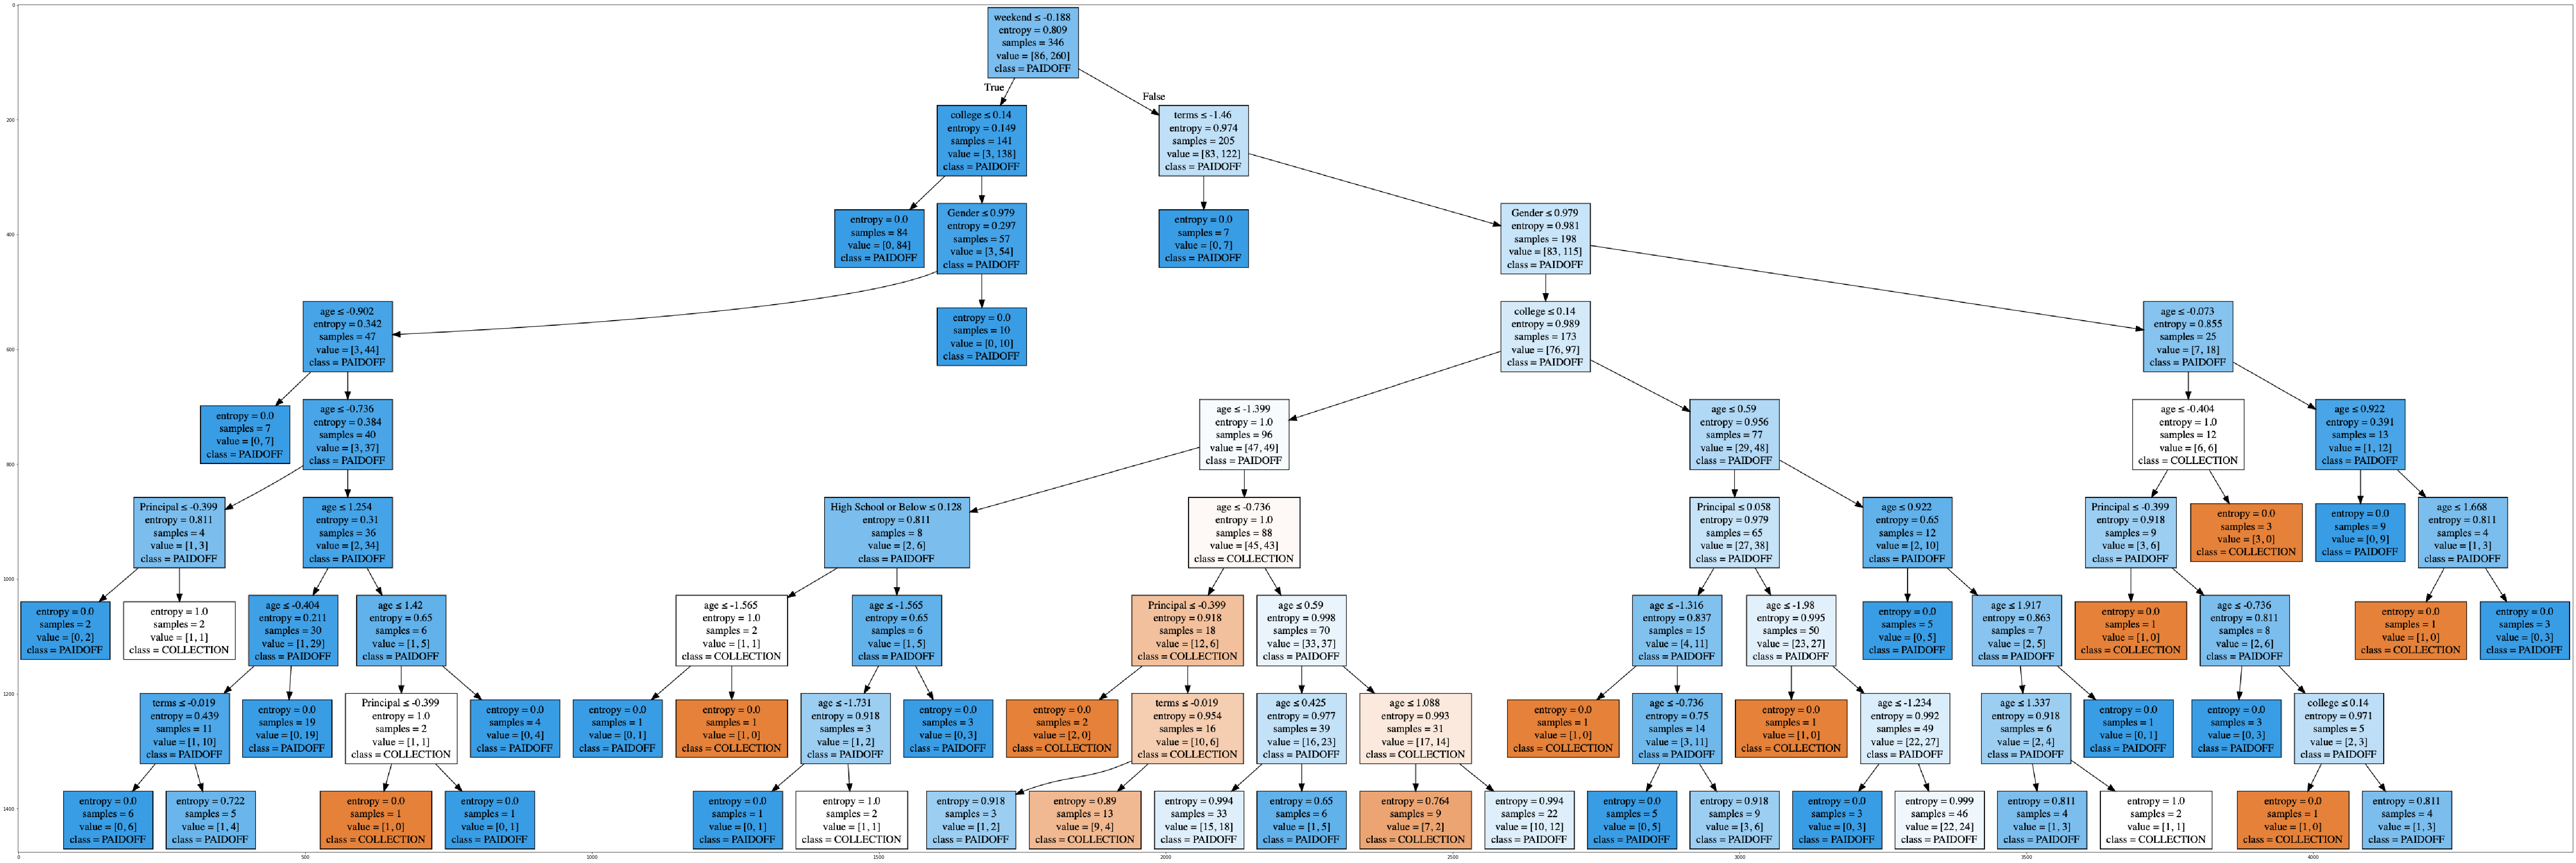

In [136]:
from sklearn.externals.six import StringIO
import pydotplus
import matplotlib.image as mpimg
from sklearn import tree

dot_data = StringIO()
filename = "loantree.png"
featureNames = Feature_test.columns
targetNames = np.unique(y)
out=tree.export_graphviz(loanTree,feature_names=featureNames, out_file=dot_data, class_names= np.unique(y), filled=True,  special_characters=True,rotate=False)  
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_png(filename)
img = mpimg.imread(filename)
plt.figure(figsize=(100, 200))
plt.imshow(img,interpolation='nearest')

# Support Vector Machine

In [165]:
#from sklearn.preprocessing import LabelEncoder
#y_svm = LabelEncoder().fit_transform(y)
#y_svm

In [234]:
from sklearn import svm

svm_mod = svm.SVC(kernel='rbf')
svm_mod.fit(X, y) 

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [235]:
yhat = svm_mod.predict(X_test)
yhat

array(['PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF'],
      dtype=object)

In [236]:
from sklearn.metrics import classification_report, confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

              precision    recall  f1-score   support

  COLLECTION       0.00      0.00      0.00        14
     PAIDOFF       0.74      1.00      0.85        40

    accuracy                           0.74        54
   macro avg       0.37      0.50      0.43        54
weighted avg       0.55      0.74      0.63        54

Confusion matrix, without normalization
[[40  0]
 [14  0]]


/Users/nicholaslepetit/opt/miniconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


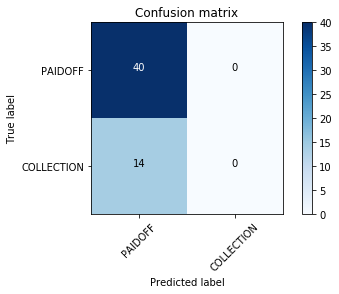

In [237]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, yhat, labels=['PAIDOFF','COLLECTION'])
np.set_printoptions(precision=2)

print (classification_report(y_test, yhat))

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['PAIDOFF','COLLECTION'],normalize= False,  title='Confusion matrix')

In [238]:
from sklearn.metrics import f1_score
from sklearn.metrics import jaccard_similarity_score

f1_svm = f1_score(y_test, yhat, average='weighted') 
jaccard_svm = jaccard_similarity_score(y_test, yhat)
print("F1 Score:", f1_svm)
print("Jaccard Score:", jaccard_svm)

F1 Score: 0.6304176516942475
Jaccard Score: 0.7407407407407407


/Users/nicholaslepetit/opt/miniconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:664: FutureWarning: jaccard_similarity_score has been deprecated and replaced with jaccard_score. It will be removed in version 0.23. This implementation has surprising behavior for binary and multiclass classification tasks.
  FutureWarning)


# Logistic Regression

In [274]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix

#y = LabelEncoder().fit_transform(y)
#y_test = LabelEncoder().fit_transform(y_test)

lr_mod = LogisticRegression(C=1, solver='liblinear').fit(X,y)
lr_mod

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [275]:
yhat_lr = lr_mod.predict(X_test)
yhat_lr

array(['PAIDOFF', 'COLLECTION', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'COLLECTION',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF'], dtype=object)

In [276]:
yhat_lr_prob = lr_mod.predict_proba(X_test)
yhat_lr_prob

array([[0.02, 0.98],
       [0.63, 0.37],
       [0.24, 0.76],
       [0.43, 0.57],
       [0.45, 0.55],
       [0.47, 0.53],
       [0.35, 0.65],
       [0.45, 0.55],
       [0.26, 0.74],
       [0.27, 0.73],
       [0.49, 0.51],
       [0.5 , 0.5 ],
       [0.46, 0.54],
       [0.22, 0.78],
       [0.27, 0.73],
       [0.38, 0.62],
       [0.36, 0.64],
       [0.18, 0.82],
       [0.4 , 0.6 ],
       [0.33, 0.67],
       [0.4 , 0.6 ],
       [0.34, 0.66],
       [0.11, 0.89],
       [0.03, 0.97],
       [0.05, 0.95],
       [0.07, 0.93],
       [0.04, 0.96],
       [0.03, 0.97],
       [0.06, 0.94],
       [0.05, 0.95],
       [0.05, 0.95],
       [0.04, 0.96],
       [0.05, 0.95],
       [0.05, 0.95],
       [0.04, 0.96],
       [0.05, 0.95],
       [0.07, 0.93],
       [0.06, 0.94],
       [0.03, 0.97],
       [0.03, 0.97],
       [0.45, 0.55],
       [0.23, 0.77],
       [0.32, 0.68],
       [0.4 , 0.6 ],
       [0.32, 0.68],
       [0.54, 0.46],
       [0.4 , 0.6 ],
       [0.35,

In [278]:
#from sklearn.metrics import jaccard_score
jaccard_similarity_score(y_test, yhat_lr)

0.7407407407407407

Confusion matrix, without normalization
[[39  1]
 [13  1]]


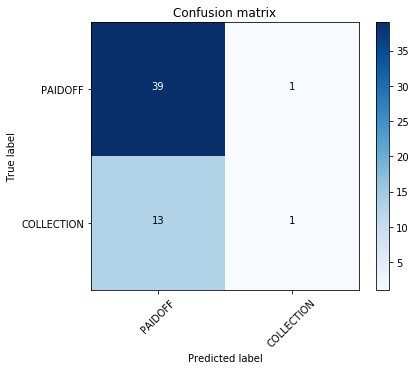

In [281]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, yhat_lr, labels=['PAIDOFF','COLLECTION'])
np.set_printoptions(precision=2)


# Plot non-normalized confusion matrix
plt.figure(figsize=(6,5))
plot_confusion_matrix(cnf_matrix, classes=['PAIDOFF','COLLECTION'],normalize= False,  title='Confusion matrix')

In [282]:
print (classification_report(y_test, yhat_lr))

              precision    recall  f1-score   support

  COLLECTION       0.50      0.07      0.12        14
     PAIDOFF       0.75      0.97      0.85        40

    accuracy                           0.74        54
   macro avg       0.62      0.52      0.49        54
weighted avg       0.69      0.74      0.66        54



In [283]:
from sklearn.metrics import log_loss
log_loss(y_test, yhat_lr_prob)

0.489752213198113

# Model Evaluation using Test set

In [284]:
from sklearn.metrics import jaccard_similarity_score
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss

First, download and load the test set:

In [ ]:
!wget -O loan_test.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv

### Load Test set for evaluation 

In [289]:
# The loading and preparation of the test set were made during the preparation stage of the KNN's algorithm
# model.

# Getting the yhats that were not in the optimal format to be utilized.
yhat_tree = pred_loanTree
yhat_svm = svm_mod.predict(X_test)

# Report
You should be able to report the accuracy of the built model using different evaluation metrics:

| Algorithm          | Jaccard | F1-score | LogLoss |
|--------------------|---------|----------|---------|
| KNN                | ?       | ?        | NA      |
| Decision Tree      | ?       | ?        | NA      |
| SVM                | ?       | ?        | NA      |
| LogisticRegression | ?       | ?        | ?       |

In [290]:
# Extracting and saving the Jaccard Similarity Score from each model.

jac_knn = jaccard_similarity_score(y_test, yhat_knn)
jac_tree = jaccard_similarity_score(y_test, yhat_tree)
jac_svm = jaccard_similarity_score(y_test, yhat_svm)
jac_lr = jaccard_similarity_score(y_test, yhat_lr)

/Users/nicholaslepetit/opt/miniconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:664: FutureWarning: jaccard_similarity_score has been deprecated and replaced with jaccard_score. It will be removed in version 0.23. This implementation has surprising behavior for binary and multiclass classification tasks.
  FutureWarning)


In [291]:
print(jac_knn, jac_tree, jac_svm, jac_lr)

0.7592592592592593 0.7407407407407407 0.7407407407407407 0.7407407407407407


In [293]:
# Extracting and saving the F1-Score from each model.

f1_knn = f1_score(y_test, yhat_knn, average='weighted')
f1_tree = f1_score(y_test, yhat_tree, average='weighted')
f1_svm = f1_score(y_test, yhat_svm, average='weighted')
f1_lr = f1_score(y_test, yhat_lr, average='weighted')

In [294]:
print(f1_knn,f1_tree,f1_svm,f1_lr)

0.6717642373556352 0.6304176516942475 0.6304176516942475 0.6604267310789049


In [295]:
# Extracting the logloss value from the Logistic Regression model.
logloss_lr = log_loss(y_test, yhat_lr_prob)

In [296]:
print(logloss_lr)

0.489752213198113


In [301]:
reportdata = {
    'Algorithm':['KNN', 'Decision Tree', 'SVM', 'Logistic Regression'],
    'Jaccard':[jac_knn, jac_tree, jac_svm, jac_lr],
    'F1-Score':[f1_knn,f1_tree,f1_svm,f1_lr],
    'Logloss':['NA','NA','NA',logloss_lr]
}

report = pd.DataFrame (reportdata)
report

,Algorithm,Jaccard,F1-Score,Logloss
0,KNN,0.759259,0.671764,NA
1,Decision Tree,0.740741,0.630418,NA
2,SVM,0.740741,0.630418,NA
3,Logistic Regression,0.740741,0.660427,0.489752


# CONCLUSION:

#### Based on the results of each respective models evaluation, we have statistical evidence to propose that the best classifier algorithm for our data, and therefore scenario, would be the K-Nearest-Neighbors algorithm (KNN), as we can note it packs a superior Jaccard Similarity Score and F1-Score both. This gives us enough indication that the KNN model's selection is the most optimal available from the experimentation and modeling done, considering that the testing was done exclusively on test sets, and represent the out-of-sample accuracy score.

##### In addition to that, we can note that the Logloss result from the Logistic Regression model, which is the only indicator available only for that model, does not provide us with enough confidence to further investigate and compare against the KNN model.

<h2>Want to learn more?</h2>

IBM SPSS Modeler is a comprehensive analytics platform that has many machine learning algorithms. It has been designed to bring predictive intelligence to decisions made by individuals, by groups, by systems – by your enterprise as a whole. A free trial is available through this course, available here: <a href="http://cocl.us/ML0101EN-SPSSModeler">SPSS Modeler</a>

Also, you can use Watson Studio to run these notebooks faster with bigger datasets. Watson Studio is IBM's leading cloud solution for data scientists, built by data scientists. With Jupyter notebooks, RStudio, Apache Spark and popular libraries pre-packaged in the cloud, Watson Studio enables data scientists to collaborate on their projects without having to install anything. Join the fast-growing community of Watson Studio users today with a free account at <a href="https://cocl.us/ML0101EN_DSX">Watson Studio</a>

<h3>Thanks for completing this lesson!</h3>

<h4>Author:  <a href="https://ca.linkedin.com/in/saeedaghabozorgi">Saeed Aghabozorgi</a></h4>
<p><a href="https://ca.linkedin.com/in/saeedaghabozorgi">Saeed Aghabozorgi</a>, PhD is a Data Scientist in IBM with a track record of developing enterprise level applications that substantially increases clients’ ability to turn data into actionable knowledge. He is a researcher in data mining field and expert in developing advanced analytic methods like machine learning and statistical modelling on large datasets.</p>

<hr>

<p>Copyright &copy; 2018 <a href="https://cocl.us/DX0108EN_CC">Cognitive Class</a>. This notebook and its source code are released under the terms of the <a href="https://bigdatauniversity.com/mit-license/">MIT License</a>.</p>